# Fitness - Metric

### Replay Fitness quantifies the extent to which the model can reproduce the traces recorded in the log.

### The quality dimension of replay Fitness describes the fraction of the behavior in the event log that can be replayed by the process model.

#### Importing Libraries

In [1]:
import os
import configparser
from datetime import date
import pandas as pd
import re
import graphviz
import math
import seaborn as sns
import collections
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
sns.set(style="whitegrid")

from tqdm import tqdm
from tqdm import trange

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

#### Profit Intialization

In [4]:
PATH = 'C:\\Users\\ashis\\Python Notebooks\\ProFIT'# path to ProFIT directory
config = configparser.ConfigParser()
config.add_section("packageLocation")
config.set("packageLocation", "workingDir", PATH)
config.set("packageLocation", "packageDir", PATH+'\\profit')


import sys
sys.path.append(config["packageLocation"]["workingDir"])
sys.path.append(config["packageLocation"]["packageDir"])


from profit import ProcessMap
pm = ProcessMap()

### Net Graph GENERATOR 

In [5]:
def Filter(net):
        temp = str(net)
        temp = temp.lower()
        temp = re.sub("\d",'', temp)
        temp = re.sub('node',' ', temp)
        temp = re.sub('\(', "", temp)
        temp = re.sub('\)', "", temp)
        temp = re.sub('\[', "", temp)
        temp = re.sub('\]', "", temp)
        temp = re.sub('\{', "", temp)
        temp = re.sub('\}', "", temp)
        temp = re.sub('connections',' ', temp)
        temp = re.sub(' ','', temp)
        
        temp = re.sub('\:',' ', temp)
        temp = re.sub('\,',' ', temp)
        temp = re.sub('\'','', temp)
        temp = re.sub('\.',' ', temp)
        temp = re.sub(' +', ' ', temp)
        temp = re.sub('"', '', temp)
        return temp
    
def Final(net):
        temp = str(net)
        temp = temp.lower()
        temp = re.sub("\d",'', temp)
        temp = re.sub('node',' ', temp)
        temp = re.sub('\(', "", temp)
        temp = re.sub('\)', "", temp)
        temp = re.sub('\[', "", temp)
        temp = re.sub('\]', "", temp)
        temp = re.sub('\{', "", temp)
        temp = re.sub('\}', "", temp)
        temp = re.sub('connections',' ', temp)
        temp = re.sub(' ','', temp)
        
        temp = re.sub('\:',' ', temp)
        temp = re.sub('\,',' ', temp)
        temp = re.sub('\'',' ', temp)
        temp = re.sub('\.',' ', temp)
        temp = re.sub(' +', ' ', temp)
        temp = re.sub('"', ' ', temp)
        HT = pd.DataFrame([x.split(' ') for x in temp.split('\n')])
        HT = HT.transpose()
        HT = HT.drop([0]).reset_index(drop = True)
        HT.columns = ['Task']
        HT= HT.drop(index=HT.index[-1])
        HT = HT.drop_duplicates(ignore_index=True)
        HT = HT.sort_values("Task").reset_index(drop = True)
        #print(HT)
    
        return HT 
    
def START_END_DEL(mainkey, subkey):
    
    SS = pd.DataFrame(subkey,mainkey).reset_index()
    SS.columns = ["mainkey", "subkey"]
    
    flag = []

    for i in range(len(SS)):
        if SS["mainkey"][i]=='start':
            flag.append(i)
        elif SS["subkey"][i] == 'end':
            flag.append(i)
    
    SS = SS.drop(flag).reset_index(drop = True)
    
    r_mainkey = list(SS["mainkey"])
    r_subkey = list(SS["subkey"])
    
    return (r_mainkey, r_subkey)


In [6]:
def MINER(in_data, act, path):

    pm.set_log(data = in_data)
          
    # Have to change "Optimize" State when using Manual Path & Activity Rates
    pm.set_params(optimize = False, aggregate = False) # Optimize = TRUE/FALSE # Agg_type = inner/outer
        
        
    # Will be activated only when "OPTIMIZE" from above is changed to "False"
    pm.set_rates(activity_rate = act, path_rate = path ) # Rates = Activity & Path rate only 
       
    # Logic on this (or in % , where 100% means complete utilization & 0% Vice Versa) 
    # Activity Rate = The precision/clarity of the model/graph being produced (i.e. when at 100 = all events are displayed, when at 5-10 low number of events with the most highest weightage are displayed)
    # Path rate = the regulation of paths (i.e. aggregation of path in %)0 = high aggregation of path, 100 % super detailed paths to every case/task
        
    pm.update() # Updates settings
        
    # pm.render() # Renders the Final Process Model
        
    print(pm.get_rates())
        
    net = pm.get_graph()
   
    return net### Net Graph GENERATOR 

### Datasets

In [7]:
df = pd.read_csv("remote_monitoring_eng.csv")
df1 = df[df['task'] != 'New med program operator']
df1 = df1.reset_index(drop = True)
df1

,case_id,task,timestamp
0,4082,Red zone operator,2018-01-10 22:09:21
1,4082,Red zone doctor FD,2018-01-12 02:44:28
2,4173,Red zone operator,2018-01-12 11:16:53
3,4176,Red zone operator,2018-01-12 11:49:30
4,4176,Red zone doctor FD,2018-01-12 11:49:50
...,...,...,...
35353,9155,Notification operator,2018-12-31 09:03:14
35354,9362,Notification operator,2018-12-31 09:03:16
35355,9758,Notification operator,2018-12-31 09:03:23
35356,9938,Notification operator,2018-12-31 09:03:26


In [8]:
ids = df1["case_id"].unique()
ids

array([ 4082,  4173,  4176,  4187,  4191,  4217,  5265,  4388,  4392,
        4422,  4454,  4401,  4476,  4553,  4494,  4545,  4521,  4539,
        4511,  4562,  4554,  4564,  4583,  4626,  4757,  4838,  4842,
        4837,  4844,  4914,  4868,  4960,  4982,  5079,  5095,  5159,
        5085,  5298,  5301,  5226,  5335,  5294,  5322,  5329,  5355,
        5361,  5389,  5372,  5376,  5441,  5443,  5424,  5457,  5534,
        5558,  5568,  5601,  5410,  5706,  5699,  5717,  5750,  5752,
         830,  5854,  5834,  5903,  5915,  5924,  5952,  5938,  5961,
        6013,  6044,  6061,  6141,  6187,  6233,  6230,  6241,  6293,
        6325,  6331,  6343,  6334,  6378,  6338,  6351,  6412,  6457,
        6502,  6503,  6522,  6563,  6545,  6616,  6632,  6649,  6659,
        6736,  6744,  6718,  6826,  6818,  6840,  6884,  6912,  6943,
        7012,  7005,  7025,  7015,  7064,  7054,  7060,  7129,  7125,
        7122,  7136,  7144,  7194,  7184,  7188,  7192,  7218,  7277,
        7321,  7313,

In [9]:
MINER(df1, 20, 20) # The Process Map 

{'activities': 20, 'paths': 20}


{('Yellow zone doctor', 'Yellow zone doctor FD'): (2415, 229),
 ('Red zone doctor', 'Red zone operator'): (2269, 228),
 ('Red zone doctor FD', 'Red zone operator'): (2245, 208),
 ('Yellow zone doctor FD', 'Notification operator'): (872, 153),
 ('Red zone doctor FD', 'Notification operator'): (537, 143),
 ('Red zone doctor FD', 'Yellow zone doctor'): (976, 207),
 ('Yellow zone doctor FD', 'Yellow zone doctor'): (1073, 168),
 ('Red zone doctor', 'Red zone doctor FD'): (2305, 244),
 ('Red zone operator', 'Red zone doctor FD'): (2158, 238),
 ('Red zone operator', 'Red zone doctor'): (3672, 251),
 ('Notification operator', 'end'): (131, 131),
 ('Yellow zone doctor FD', 'Red zone operator'): (642, 154),
 ('Notification operator', 'Yellow zone doctor'): (633, 133),
 ('start', 'Red zone operator'): (189, 189),
 ('Red zone doctor FD', 'Red zone doctor FD'): (1429, 184)}

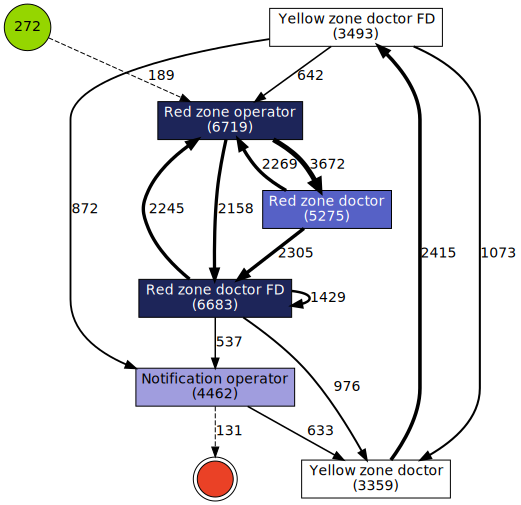

In [10]:
pm.render()

# FINAL EXECUTION HERE...!!!

### Activity is Varied (0-100), Path is Constant (0,20,40,60,80,100)

In [11]:
Act = [] # Stores the ACT Figure
Fit = [] # Stores the State of Fitting 1 or 0 



PATH_THRES = [5,20,40,60,80,100]


for outer_j in trange(len(PATH_THRES)):
    
    Act = [] # Stores the ACT Figure
    Fit = [] # Stores the State of Fitting 1 or 0 

    INDI_FIT = []
    fitter = 0
    
    
    THE_FATHERLOAD = []
    
    COV_COV = 0
    ID = []
    LOG_LEN = []
    MAP_LEN = []
    FIT_STS = []
    COV_MAP = []
    
    
    for count in trange(0,101,1):  
        
        keys = [] # To store Initial keys FRoM MAP
    
        mainkey = [] # Source Keys
        subkey = [] # Destination Keys 
        
        startindex = 0 # To store START keyword index
        endindex = 0 # To store END keyword Index
        
        #-------------------------------------------------------------------------------------------------------------------------
        # Net Assignment 
        INPUT = MINER(df1, count, PATH_THRES[outer_j]) # The Process MAP that is to be compared is entered here (Dataset is entered here) # MAP HERE
        #-------------------------------------------------------------------------------------------------------------------------
    
    
        #-------------------------------------------------------------------------------------------------------------------------
        # Assigning key to main List 
        for key in INPUT:
            #print(key)
            keys.append(key)
        #-------------------------------------------------------------------------------------------------------------------------
        
    
        #-------------------------------------------------------------------------------------------------------------------------
        # Key Segregation 
        for i in range(len(keys)):
            T1 = keys[i]
            T2 = Filter(T1)
            T3 = T2.split(' ')
            mainkey.append(T3[0])
            subkey.append(T3[1])  
        #-------------------------------------------------------------------------------------------------------------------------
    
        
        #-------------------------------------------------------------------------------------------------------------------------    
        
        # DELETION of START & END Keyword
        
        mainkey, subkey = START_END_DEL(mainkey,subkey)
                        
    #-------------------------------------------------------------------------------------------------------------------------
    
    
    #-------------------------------------------------------------------------------------------------------------------------
        t_i = mainkey[0]
        k=0
        a = collections.defaultdict(list)
        
        while k < len(mainkey):
            # dynamically create key
            if k == 0:
                key = mainkey[k]
                
            if t_i == mainkey[k]:
                value = subkey[k]
                a[key].append(value)
                k+=1
            else:
                if t_i != mainkey[k]:
                    t_i = mainkey[k]
                    key = mainkey[k]
                    value = subkey[k]
                    a[key].append(value)
                    k+=1
    #-------------------------------------------------------------------------------------------------------------------------
    
        #THE_FATHERLOAD.append(a)
        
        
        #COMPARISON PHASE
    #-------------------------------------------------------------------------------------------------------------------------

        final_state = 0 # SHOULD BE REFRESHED FOR EVERY ITERATION OF THE PROCESS MODEL (i.e. every new process map & not every ID)
    #-------------------------------------------------------------------------------------------------------------------------    
        for i in range(len(ids)): # INDIVIDUAL LOOPING OF EACH ID
            
            df3 = df1[df1["case_id"]== ids[i]].reset_index(drop = True) # THE ID for each Dataset is mentioned here
        
            trace = df3.copy() # ID CARRYING VARIABLE
    
    #-------------------------------------------------------------------------------------------------------------------------
    
            for j in range(len(trace)):
                trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE
    
    #-------------------------------------------------------------------------------------------------------------------------
    # MODULE TO SELECT THE STARTING POINT & CHECK IF IT CAN BE REPLICATED IN THE PROCESS MAP
        #F_in = trace["task"][0] # initial state
        
            #for k in range(len(a.keys())):
                #if F_in == list(a.keys())[k]:
                    #print("true", k)
        
    #-------------------------------------------------------------------------------------------------------------------------
            flag_s1 = 0 # OUTER FLAG (START POINT FLAG)
            flag_s2 = 0 # INNER FLAG (END POINT FLAG)
        
            decider = [] # Resets for Every ID
            
            for m in range(0,len(trace)-1,1):
            #print(trace["task"][i])
            
                flag_s1 = 0
                flag_s2 = 0
            
                state1 = trace["task"][m]
                state2 = trace["task"][m+1]
                    
                for n in range(len(a.keys())):
                    if state1 == list(a.keys())[n]:
                        flag_s1 = 1
                        var_s1 = state1 # Starting point of the line (INTIAL POINT)
                        
                        for s in range(len(a[var_s1])):
                            if state2 == a[var_s1][s]:
                                flag_s2 = 1
                                decider.append(1) # (ONLY AFTER THE CONNECTION IS VERIFIED THAT THE CONDITION IS CONVERETED TO 1)
                
                
            #print("\n\t\tID = ", ids[i])
            ID.append(ids[i])
            
            #print("\n\t\tLength of trace = ", len(trace))
            LOG_LEN.append(len(trace))
            
            #print("\t\tTotal paths covered  = ", sum(decider)+1)
            MAP_LEN.append(sum(decider)+1)
        
            COV_COV = ((sum(decider)+1)/len(trace)*100)
            
            #print("\t\tCOVERAGE = ", COV_COV)
            COV_MAP.append(COV_COV)
            
            
            if len(trace) == (sum(decider)+1):
                final_state+=1
                #print("\t\tThis ID Is FIT")
                FIT_STS.append(1)
                fitter+=1
            else:
                #print("\t\tNot Fit")
                FIT_STS.append(0)
            
            #print("\n\t\t PATH RATE:", count)
            
            #print("\t\tModel Fitness %:", final_state/len(ids)*100)
            #print("\t\t--------------------------------NEXT ID---------------------------------------")                   
            #Path.append(count)
            #Fit.append((final_state/len(ids))*100)
            
            if i == len(ids)-1:
                INDI_FIT.append((fitter/len(ids))*100) # 272 = len of ids
                fitter=0
        
        Act.append(count)
            
        if outer_j == 0:
            res_SA0 = pd.DataFrame({"Path_Rate":Act,"Fitness":INDI_FIT})
                #res_af1
        
        elif outer_j == 1:
            res_SA1 = pd.DataFrame({"Path_Rate":Act,"Fitness":INDI_FIT})
                #res_af1
    
        elif outer_j == 2:
            res_SA2 = pd.DataFrame({"Path_Rate":Act,"Fitness":INDI_FIT})
    
        elif outer_j == 3:
            res_SA3 = pd.DataFrame({"Path_Rate":Act,"Fitness":INDI_FIT})
    
        elif outer_j == 4:
            res_SA4 = pd.DataFrame({"Path_Rate":Act,"Fitness":INDI_FIT})
    
        elif outer_j == 5:
            res_SA5 = pd.DataFrame({"Path_Rate":Act,"Fitness":INDI_FIT})
        
        print("Fitness = ", (fitter/len(ids))*100)
        print("\n\n-----------------------------------------------------------------------------------------")                   
        print("-----------------------------------NEXT ID OVER HERE-------------------------------------\n\n")                   
    
    #print("\n\n Total Number of FIT executions are ", final_state, "out of a Total of", len(ids), "IDs")
    #print("Fitness Rating = :", (final_state/len(ids))*100)
    
ACT_FULL = res_SA0.copy()
ACT_FULL = ACT_FULL.merge(res_SA1, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_SA2, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_SA3, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_SA4, on='Path_Rate', how='right')
ACT_FULL = ACT_FULL.merge(res_SA5, on='Path_Rate', how='right')

ACT_FULL.columns = ['Activity_Rate', 'Path = 5', 'Path = 20' ,'Path = 40', 'Path = 60','Path = 80','Path = 100']

ACT_FULL

{'activities': 0, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 1, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 2, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 3, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 4, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 6, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 7, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 8, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 9, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 10, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 11, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 12, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 13, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 14, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 15, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 16, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 17, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 18, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 19, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 0, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 1, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 2, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 3, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 4, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 6, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 7, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 8, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 9, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 10, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 11, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 12, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 13, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 14, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 15, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 16, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 17, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 18, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 19, 'paths': 20}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 0, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 1, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 2, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 3, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 4, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 6, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 7, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 8, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 9, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 10, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 11, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 12, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 13, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 14, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 15, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 16, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 17, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 18, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 19, 'paths': 40}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 0, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 1, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 2, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 3, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 4, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 6, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 7, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 8, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 9, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 10, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 11, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 12, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 13, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 14, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 15, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 16, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 17, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 18, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 19, 'paths': 60}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 0, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 1, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 2, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 3, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 4, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 6, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 7, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 8, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 9, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 10, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 11, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 12, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 13, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 14, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 15, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 16, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 17, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 18, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 19, 'paths': 80}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 0, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 1, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 2, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 3, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 4, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 5, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 6, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 7, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 8, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 9, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 10, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 11, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 12, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 13, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 14, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 15, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 16, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 17, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 18, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 19, 'paths': 100}


C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------




C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:233: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Fitness_x'} in the result is deprecated and will raise a MergeError in a future version.
  ACT_FULL = ACT_FULL.merge(res_SA3, on='Path_Rate', how='right')
C:\Users\ashis\AppData\Local\Temp\ipykernel_20096\889640330.py:235: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Fitness_x'} in the result is deprecated and will raise a MergeError in a future version.
  ACT_FULL = ACT_FULL.merge(res_SA5, on='Path_Rate', how='right')


,Activity_Rate,Path = 5,Path = 20,Path = 40,Path = 60,Path = 80,Path = 100
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,1.102941,1.102941,1.102941,1.102941,1.102941,1.470588
5,5,1.102941,1.102941,1.102941,1.102941,1.102941,1.470588
6,6,1.102941,1.102941,1.102941,1.102941,1.102941,1.470588
7,7,1.102941,1.102941,1.102941,1.102941,1.102941,1.470588
8,8,1.102941,1.102941,1.102941,1.102941,1.102941,1.470588
9,9,1.102941,1.102941,1.102941,1.102941,1.102941,1.470588


In [ ]:
ACT_FULL.to_csv("Sample_5_Fitness_ACT.csv")

In [ ]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Activity_Rate', y='value', hue='variable', data=pd.melt(ACT_FULL, ['Activity_Rate']), lw = 2)
plt.xlabel("Activity (0-100%)")
plt.ylabel("Fitness Rating")
plt.title("Fitness - When Activity is Varied b/w (0 - 100 )& Path is kept Constant")
plt.show()

## When Activites is Constant [0,20,40,60,80,100], & path is varied between (0-100)

In [29]:
Path = [] # Stores the ACT Figure
Fit = [] # Stores the State of Fitting 1 or 0 



ACT_THRES = [5,20,40,60,80,100]


for outer_j in trange(len(ACT_THRES)):
    
    Path = [] # Stores the ACT Figure
    Fit = [] # Stores the State of Fitting 1 or 0 

    INDI_FIT = []
    fitter = 0
    
    
    THE_FATHERLOAD = []
    
    COV_COV = 0
    ID = []
    LOG_LEN = []
    MAP_LEN = []
    FIT_STS = []
    COV_MAP = []
    
    
    for count in trange(0,101,1):  
        
        keys = [] # To store Initial keys FRoM MAP
    
        mainkey = [] # Source Keys
        subkey = [] # Destination Keys 
        
        startindex = 0 # To store START keyword index
        endindex = 0 # To store END keyword Index
        
        #-------------------------------------------------------------------------------------------------------------------------
        # Net Assignment 
        INPUT = MINER(df1, ACT_THRES[outer_j], count) # The Process MAP that is to be compared is entered here (Dataset is entered here) # MAP HERE
        #-------------------------------------------------------------------------------------------------------------------------
    
    
        #-------------------------------------------------------------------------------------------------------------------------
        # Assigning key to main List 
        for key in INPUT:
            #print(key)
            keys.append(key)
        #-------------------------------------------------------------------------------------------------------------------------
        
    
        #-------------------------------------------------------------------------------------------------------------------------
        # Key Segregation 
        for i in range(len(keys)):
            T1 = keys[i]
            T2 = Filter(T1)
            T3 = T2.split(' ')
            mainkey.append(T3[0])
            subkey.append(T3[1])  
        #-------------------------------------------------------------------------------------------------------------------------
    
        
        #-------------------------------------------------------------------------------------------------------------------------    
        
        # DELETION of START & END Keyword
        
        mainkey, subkey = START_END_DEL(mainkey,subkey)
                        
    #-------------------------------------------------------------------------------------------------------------------------
        
        if mainkey != []:
    
    #-------------------------------------------------------------------------------------------------------------------------
            t_i = mainkey[0]
            k=0
            a = collections.defaultdict(list)

            while k < len(mainkey):
                # dynamically create key
                if k == 0:
                    key = mainkey[k]

                if t_i == mainkey[k]:
                    value = subkey[k]
                    a[key].append(value)
                    k+=1
                else:
                    if t_i != mainkey[k]:
                        t_i = mainkey[k]
                        key = mainkey[k]
                        value = subkey[k]
                        a[key].append(value)
                        k+=1
        #-------------------------------------------------------------------------------------------------------------------------

            #THE_FATHERLOAD.append(a)


            #COMPARISON PHASE
        #-------------------------------------------------------------------------------------------------------------------------

            final_state = 0 # SHOULD BE REFRESHED FOR EVERY ITERATION OF THE PROCESS MODEL (i.e. every new process map & not every ID)
        #-------------------------------------------------------------------------------------------------------------------------    
            for i in range(len(ids)): # INDIVIDUAL LOOPING OF EACH ID

                df3 = df1[df1["case_id"]== ids[i]].reset_index(drop = True) # THE ID for each Dataset is mentioned here

                trace = df3.copy() # ID CARRYING VARIABLE

        #-------------------------------------------------------------------------------------------------------------------------

                for j in range(len(trace)):
                    trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE

        #-------------------------------------------------------------------------------------------------------------------------
        # MODULE TO SELECT THE STARTING POINT & CHECK IF IT CAN BE REPLICATED IN THE PROCESS MAP
            #F_in = trace["task"][0] # initial state

                #for k in range(len(a.keys())):
                    #if F_in == list(a.keys())[k]:
                        #print("true", k)

        #-------------------------------------------------------------------------------------------------------------------------
                flag_s1 = 0 # OUTER FLAG (START POINT FLAG)
                flag_s2 = 0 # INNER FLAG (END POINT FLAG)

                decider = [] # Resets for Every ID

                for m in range(0,len(trace)-1,1):
                #print(trace["task"][i])

                    flag_s1 = 0
                    flag_s2 = 0

                    state1 = trace["task"][m]
                    state2 = trace["task"][m+1]

                    for n in range(len(a.keys())):
                        if state1 == list(a.keys())[n]:
                            flag_s1 = 1
                            var_s1 = state1 # Starting point of the line (INTIAL POINT)

                            for s in range(len(a[var_s1])):
                                if state2 == a[var_s1][s]:
                                    flag_s2 = 1
                                    decider.append(1) # (ONLY AFTER THE CONNECTION IS VERIFIED THAT THE CONDITION IS CONVERETED TO 1)


                #print("\n\t\tID = ", ids[i])
                ID.append(ids[i])

                #print("\n\t\tLength of trace = ", len(trace))
                LOG_LEN.append(len(trace))

                #print("\t\tTotal paths covered  = ", sum(decider)+1)
                MAP_LEN.append(sum(decider)+1)

                COV_COV = ((sum(decider)+1)/len(trace)*100)

                #print("\t\tCOVERAGE = ", COV_COV)
                COV_MAP.append(COV_COV)


                if len(trace) == (sum(decider)+1):
                    final_state+=1
                    #print("\t\tThis ID Is FIT")
                    FIT_STS.append(1)
                    fitter+=1
                else:
                    #print("\t\tNot Fit")
                    FIT_STS.append(0)

                #print("\n\t\t PATH RATE:", count)

                #print("\t\tModel Fitness %:", final_state/len(ids)*100)
                #print("\t\t--------------------------------NEXT ID---------------------------------------")                   
                #Path.append(count)
                #Fit.append((final_state/len(ids))*100)

                if i == len(ids)-1:
                    INDI_FIT.append((fitter/len(ids))*100) # 272 = len of ids
                    fitter=0
                    print("Fitness = ", (fitter/len(ids))*100)

            Path.append(count)
        else:
            Path.append(count)
            INDI_FIT.append(0)
            print("Fitness =  0")
            
    if outer_j == 0:
        res_FA0 = pd.DataFrame({"Activity_Rate":Path,"Fitness":INDI_FIT})
            #res_af1

    elif outer_j == 1:
        res_FA1 = pd.DataFrame({"Activity_Rate":Path,"Fitness":INDI_FIT})
            #res_af1

    elif outer_j == 2:
        res_FA2 = pd.DataFrame({"Activity_Rate":Path,"Fitness":INDI_FIT})

    elif outer_j == 3:
        res_FA3 = pd.DataFrame({"Activity_Rate":Path,"Fitness":INDI_FIT})

    elif outer_j == 4:
        res_FA4 = pd.DataFrame({"Activity_Rate":Path,"Fitness":INDI_FIT})

    elif outer_j == 5:
        res_FA5 = pd.DataFrame({"Activity_Rate":Path,"Fitness":INDI_FIT})
        
        
        print("\n\n-----------------------------------------------------------------------------------------")                   
        print("-----------------------------------NEXT ID OVER HERE-------------------------------------\n\n")                   
    
    #print("\n\n Total Number of FIT executions are ", final_state, "out of a Total of", len(ids), "IDs")
    #print("Fitness Rating = :", (final_state/len(ids))*100)
    
Path_FULL = res_FA0.copy()
Path_FULL = Path_FULL.merge(res_FA1, on='Activity_Rate', how='right')
Path_FULL = Path_FULL.merge(res_FA2, on='Activity_Rate', how='right')
Path_FULL = Path_FULL.merge(res_FA3, on='Activity_Rate', how='right')
Path_FULL = Path_FULL.merge(res_FA4, on='Activity_Rate', how='right')
Path_FULL = Path_FULL.merge(res_FA5, on='Activity_Rate', how='right')

Path_FULL.columns = ['Path_Rate', 'Activity = 5', 'Activity = 20' ,'Activity = 40', 'Activity = 60','Activity = 80','Activity = 100']

Path_FULL

{'activities': 0, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_15232\1190309556.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE




-----------------------------------------------------------------------------------------
-----------------------------------NEXT ID OVER HERE-------------------------------------


{'activities': 1, 'paths': 5}


C:\Users\ashis\AppData\Local\Temp\ipykernel_15232\1190309556.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace["task"][j] = Filter(trace["task"][j]) # FILTEREING THE INDIVIDUAL TRACE INPUT FROM ABOVE


KeyboardInterrupt: 

In [ ]:
PATH_FULL.to_csv("Sample_5_Fitness_PATH.csv")

In [ ]:
figure(figsize=(12, 8), dpi=100)
sns.lineplot(x='Path_Rate', y='value', hue='variable', data=pd.melt(Path_FULL, ['Path_Rate']), lw = 2)
plt.xlabel("Path (0-100%)")
plt.ylabel("Fitness Rating")
plt.title("Fitness - When Activity is Path is kept Constant & Varied b/w (0 - 100 )")
plt.show()